In [211]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [212]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [213]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [214]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results

# Setup

## variables

In [215]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [216]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS_diff'], train0_df['ffef_tr_diff'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS_diff'], test0_df['ffef_tr_diff'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS_diff'], train0_df['ffef_tr2_diff'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS_diff'], test0_df['ffef_tr2_diff'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_train', train0_df['FEDFUNDS_diff'], np.zeros(train0_df.shape[0]), train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS_diff'], np.zeros(test0_df.shape[0]), test0_df.shape[0],1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (197, 22)
test_df:  (49, 22)


name     r_sq  adj_r_sq     mse    rmse
0   ffef_tr_train   0.0328    0.0279  0.9061  0.9519
1    ffef_tr_test -13.6332  -13.9446  2.2484  1.4995
2  ffef_tr2_train  -0.3337   -0.3406  1.2494  1.1178
3   ffef_tr2_test   0.5059    0.4954  0.0759  0.2755
4     Naive_train  -0.0001   -0.0001  0.9369  0.9680
5      Naive_test  -0.0633   -0.0633  0.1634  0.4042

# Explore

In [217]:
t_df = load_taylor()
m_df = load_misery()
chair_df = get_fed_chair()

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
t_df: (832, 3)
u_df: (909, 1)
misery_df: (825, 6)


In [218]:
m_df[['FEDFUNDS_diff','FEDFUNDS','m_index']]

FEDFUNDS_diff  FEDFUNDS  m_index
DATE                                        
1955-01-01           0.11      1.39  4.26897
1955-02-01          -0.10      1.29  4.07014
1955-03-01           0.06      1.35  4.08013
1955-04-01           0.08      1.43  4.43939
1955-05-01           0.00      1.43  3.70587
...                   ...       ...      ...
2023-05-01           0.23      5.06  7.82884
2023-06-01           0.02      5.08  6.69200
2023-07-01           0.04      5.12  6.79908
2023-08-01           0.21      5.33  7.50750
2023-09-01           0.00      5.33  7.48990

[825 rows x 3 columns]

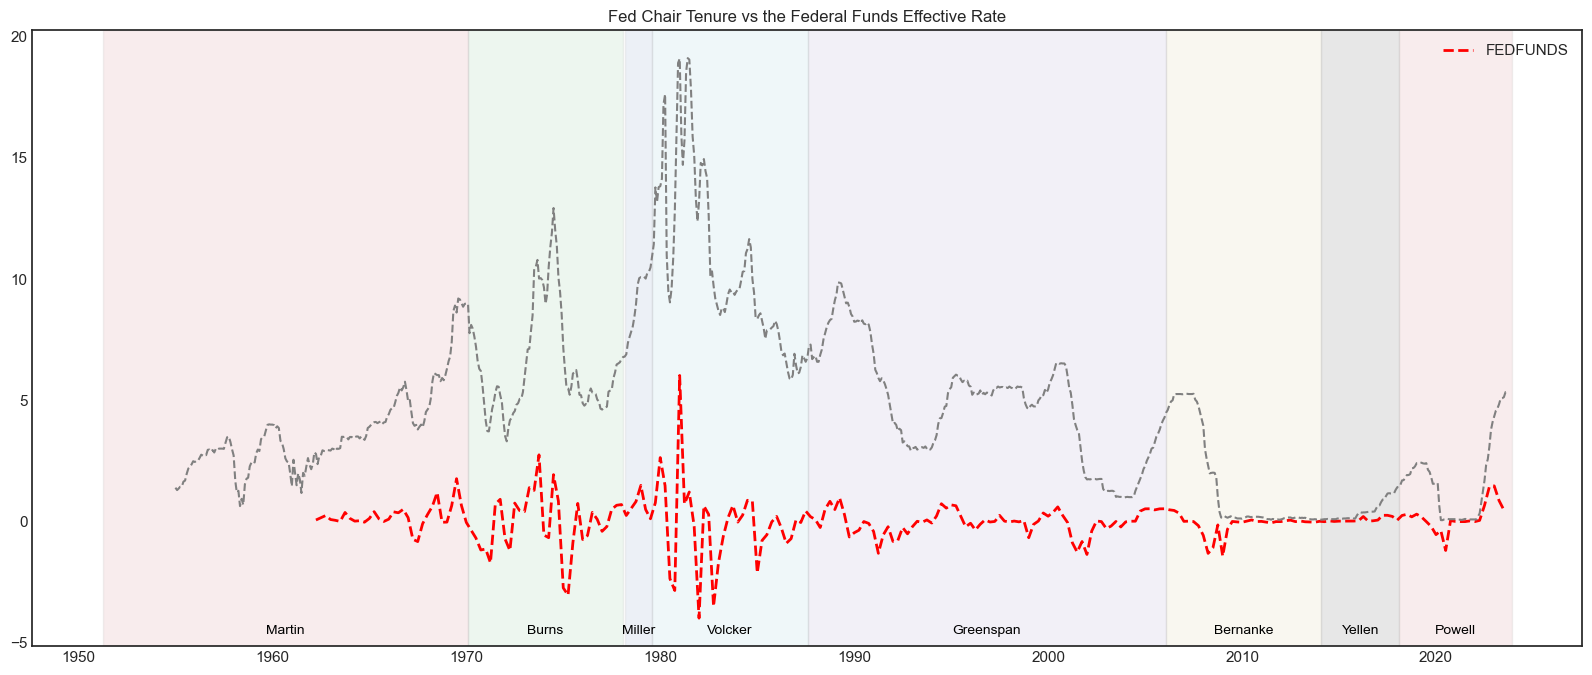

In [219]:
cycol = cycle('rgbcmyk')
min_value = m_df[['FEDFUNDS_diff','FEDFUNDS','m_index']].values.min() + 2


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS_diff'], color='red', linestyle='--',linewidth=2)
ax.plot(m_df.index, m_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=1.5) 
    
# Plotting Chair Tenure
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=10, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS"])
#plt.legend()
plt.grid(False)
ax.set(title='Fed Chair Tenure vs the Federal Funds Effective Rate');
plt.show()

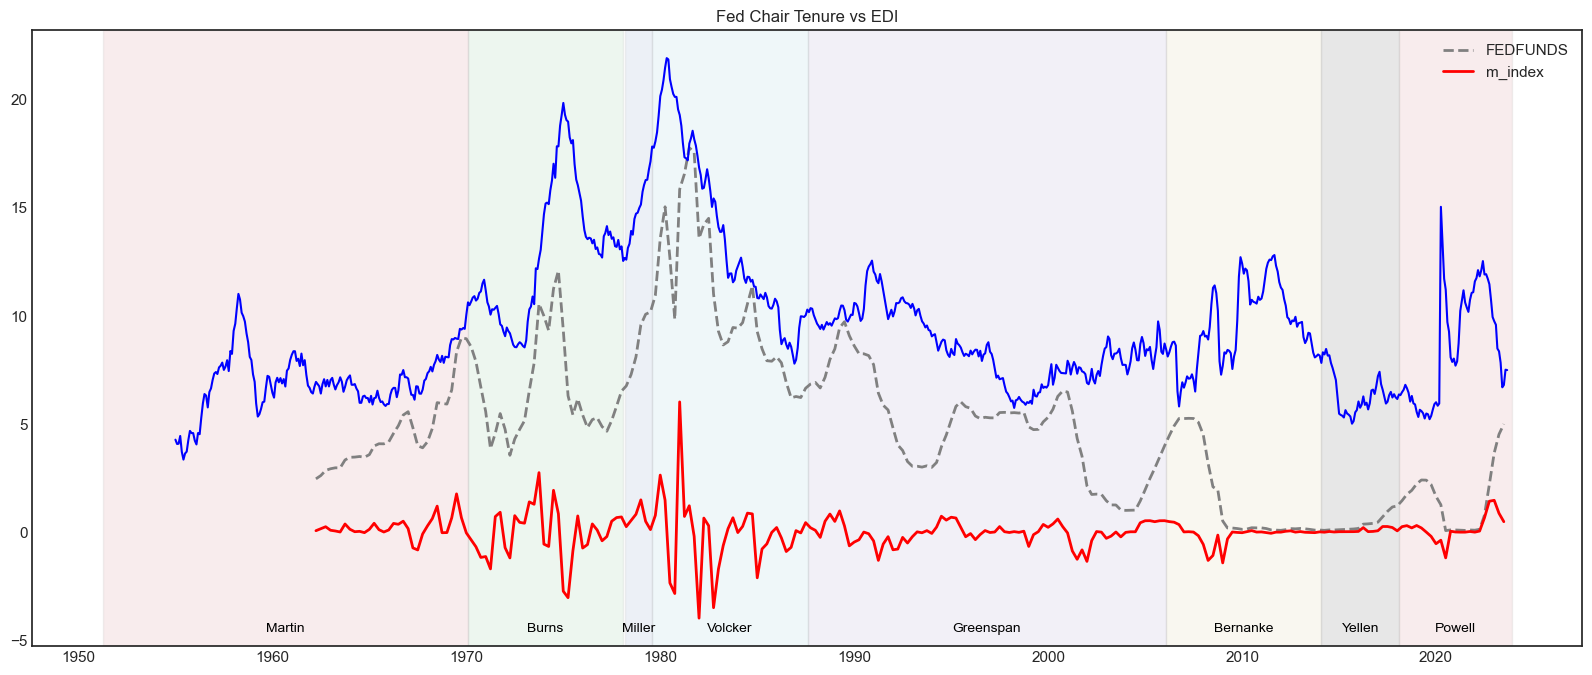

In [220]:
cycol = cycle('rgbcmyk')
min_value = m_df[['FEDFUNDS_diff','FEDFUNDS','m_index']].values.min() + 2


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--',color='gray',linewidth=2)
ax.plot(t_df.index, t_df['FEDFUNDS_diff'], color='red',linewidth=2)
ax.plot(m_df.index, m_df['m_index'],  color='blue',linewidth=1.5) 
    
# Plotting Chair Tenure
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=10, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","m_index"])
ax.set(title='Fed Chair Tenure vs EDI');
plt.show()

In [221]:
t_df[['FEDFUNDS','UNRATE','GDPDEF_PC1','gap_inf','gap_gdp','gap_ue','chair_name','Real_Interest_Rate','chair_index']].groupby('chair_name').mean().round(2).sort_values(by='chair_index')

FEDFUNDS  UNRATE  GDPDEF_PC1  gap_inf  gap_gdp  gap_ue  \
chair_name                                                           
Martin          4.58    4.44        2.58     0.60     9.46    0.56   
Burns           6.49    6.28        6.26     4.51     6.53   -1.28   
Miller          8.66    5.97        7.33     6.50     8.62   -0.97   
Volcker        10.69    7.75        5.35     4.33     4.49   -2.75   
Greenspan       4.82    5.54        2.43     1.09     6.86   -0.54   
Bernanke        1.57    7.29        1.90     0.24     5.00   -2.29   
Yellen          0.40    5.17        1.35    -0.72     5.80   -0.17   
Powell          1.55    4.81        3.48     1.75     7.32    0.19   

            Real_Interest_Rate  chair_index  
chair_name                                   
Martin                    4.85          8.0  
Burns                     3.80          9.0  
Miller                    3.62         10.0  
Volcker                   3.53         11.0  
Greenspan                 3.06         12.0  
Bernanke                  1.31         13.0  
Yellen                    0.66         14.0  
Powell                    0.94         15.0

In [222]:
m_df.reset_index(inplace=True)

m_df['chair_name'] = None
m_df['chair_index'] = 0
for i, row in chair_df.iterrows():
    m_df['chair_name'] = m_df['chair_name'].where((m_df['DATE'] < row['Start_Date']) | (m_df['DATE'] > row['End_Date']), row['Name'] )
    m_df['chair_index'] = m_df['chair_index'].where((m_df['DATE'] < row['Start_Date']) | (m_df['DATE'] > row['End_Date']), i )

m_df.set_index('DATE',inplace=True)

In [223]:
df = m_df[['FEDFUNDS','UNRATE','CPIAUCSL_PC1','m_index','chair_name']].groupby('chair_name').mean().round(2).sort_values(by='m_index', ascending=False)
df

FEDFUNDS  UNRATE  CPIAUCSL_PC1  m_index
chair_name                                         
Miller          9.24    5.89          9.23    15.12
Volcker        10.61    7.75          6.17    13.93
Burns           6.47    6.31          6.52    12.82
Bernanke        1.53    7.31          2.22     9.52
Greenspan       4.80    5.53          3.09     8.62
Powell          1.72    4.78          3.79     8.57
Martin          3.65    4.85          2.13     6.98
Yellen          0.46    5.06          1.32     6.38

# Models

## Load Data

In [224]:
taylor_df = load_taylor()
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (197, 22)
test_df:  (49, 22)


In [225]:
taylor_df['chair_name'].unique()

array(['Martin', 'Burns', 'Miller', 'Volcker', 'Greenspan', 'Bernanke',
       'Yellen', 'Powell'], dtype=object)

In [226]:
X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','recession_flag','chair_name']]
y_train = train_df['FEDFUNDS_diff']


X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','recession_flag','chair_name']]
y_test = test_df['FEDFUNDS_diff']

In [227]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler_num = RobustScaler()
#scaler_num = StandardScaler()
#scaler_num = Normalizer()
#scaler_num = PowerTransformer()

# Initialize Transformer / OneHotEncoder
cat_columns_lst = ['recession_flag','chair_name']
num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue']


ohe_categories = list()
for c in cat_columns_lst:
    ohe_categories.append(list(X_train[c].unique()))
    
ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                   sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


#numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [228]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)

X_train_trf:  (197, 9)


In [229]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_trf: ', X_test_trf.shape)

X_test_trf:  (49, 9)


In [230]:
X_test_trf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2011-06-30 to 2023-06-30
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   num__FEDFUNDS-1                           49 non-null     float64
 1   num__gap_inf                              49 non-null     float64
 2   num__gap_ue                               49 non-null     float64
 3   cat__onehotencoder__recession_flag_True   49 non-null     float64
 4   cat__onehotencoder__chair_name_Burns      49 non-null     float64
 5   cat__onehotencoder__chair_name_Miller     49 non-null     float64
 6   cat__onehotencoder__chair_name_Volcker    49 non-null     float64
 7   cat__onehotencoder__chair_name_Greenspan  49 non-null     float64
 8   cat__onehotencoder__chair_name_Bernanke   49 non-null     float64
dtypes: float64(9)
memory usage: 3.8 KB


## Stats Model - Taylor Index

In [231]:
X_train_const = sm.add_constant(X_train_trf)
print('X_train_const: ', X_train_const.shape)

X_train_const:  (197, 10)


In [232]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          FEDFUNDS_diff   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     6.879
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           1.55e-08
Time:                        20:55:37   Log-Likelihood:                -244.93
No. Observations:                 197   AIC:                             509.9
Df Residuals:                     187   BIC:                             542.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.0871      0.172     -0.505      0.614      -0.427       0.253
num__FEDFUNDS-1                             -0.6894      0.167     -4.124      0.000      -1.019      -0.360
num__gap_inf                                 0.4817      0.108      4.447      0.000       0.268       0.695
num__gap_ue                                  0.4781      0.111      4.308      0.000       0.259       0.697
cat__onehotencoder__recession_flag_True     -0.8686      0.213     -4.073      0.000      -1.289      -0.448
cat__onehotencoder__chair_name_Burns         0.0143      0.266      0.054      0.957      -0.511       0.539
cat__onehotencoder__chair_name_Miller        0.3134      0.436      0.720      0.473      -0.546       1.173
cat__onehotencoder__chair_name_Volcker       0.9943      0.360      2.764      0.006       0.285       1.704
cat__onehotencoder__chair_name_Greenspan     0.0322      0.193      0.167      0.868      -0.348       0.412
cat__onehotencoder__chair_name_Bernanke      0.1541      0.285      0.541      0.589      -0.407       0.716
==============================================================================
Omnibus:                       38.790   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              435.135
Skew:                           0.080   Prob(JB):                     3.25e-95
Kurtosis:                      10.279   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [233]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [234]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], 2 , model_stats_df )

### Test

In [235]:
X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (49, 10)


In [236]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(49, 6)

In [237]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], 2 , model_stats_df )

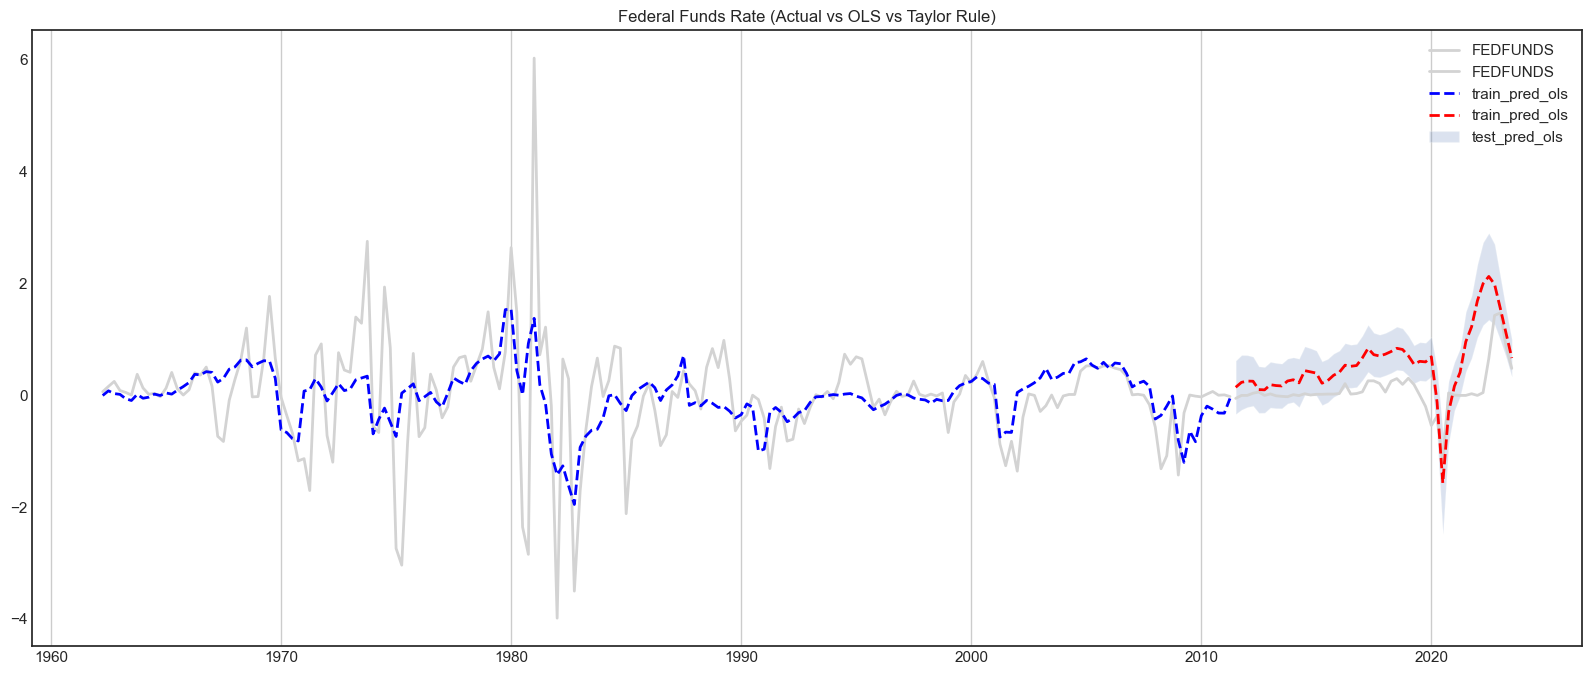

In [238]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# Lasso

In [239]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.01140949908505447


In [240]:
lasso_best = linear_model.Lasso(alpha=model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [241]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

coef
cat__onehotencoder__recession_flag_True  -0.784912
cat__onehotencoder__chair_name_Volcker    0.552311
num__FEDFUNDS-1                          -0.505396
num__gap_inf                              0.396230
num__gap_ue                               0.361627
cat__onehotencoder__chair_name_Burns     -0.022288
cat__onehotencoder__chair_name_Greenspan -0.017561
cat__onehotencoder__chair_name_Miller     0.000000
cat__onehotencoder__chair_name_Bernanke   0.000000

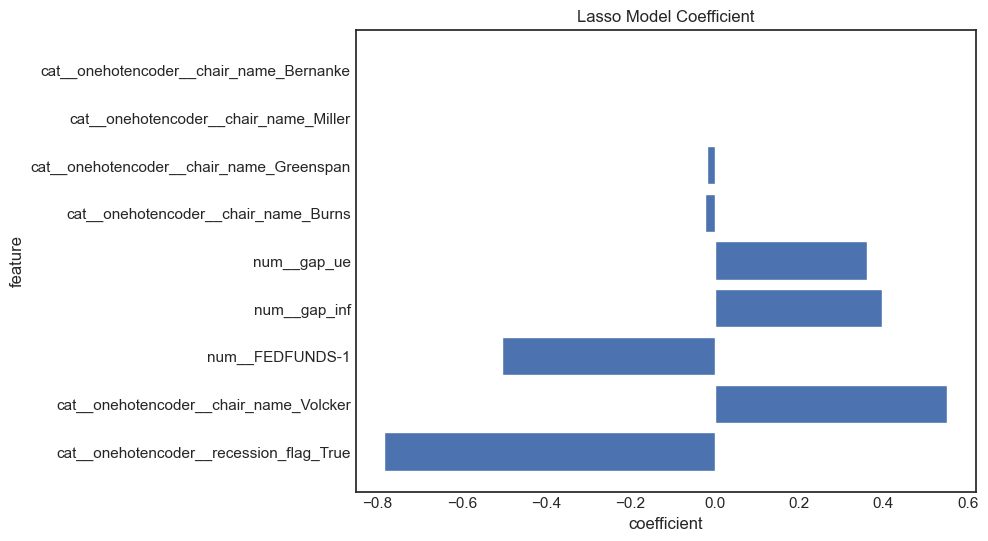

In [242]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

In [243]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], 2 , model_stats_df )

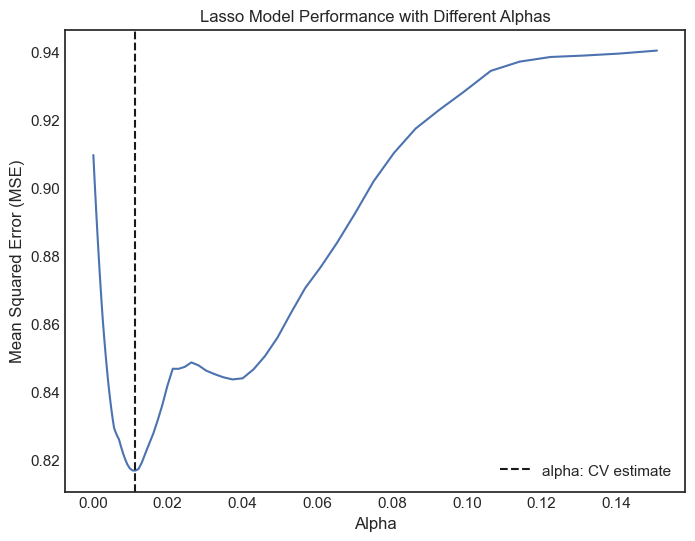

In [244]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

(-0.007382974955558362,
 0.1583606650579878,
 -0.05089313176641484,
 3.187214752315997)

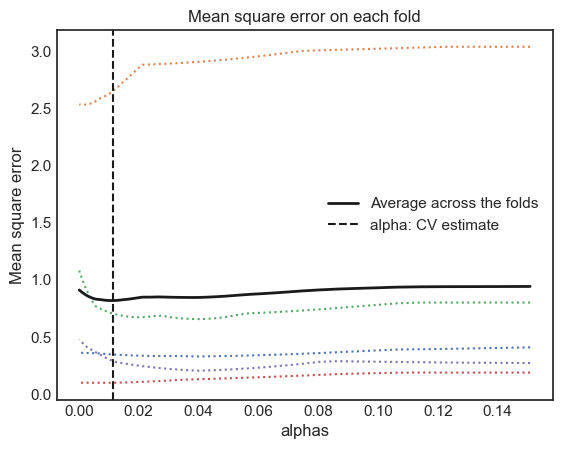

In [245]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

In [246]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (49,)


In [247]:
model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

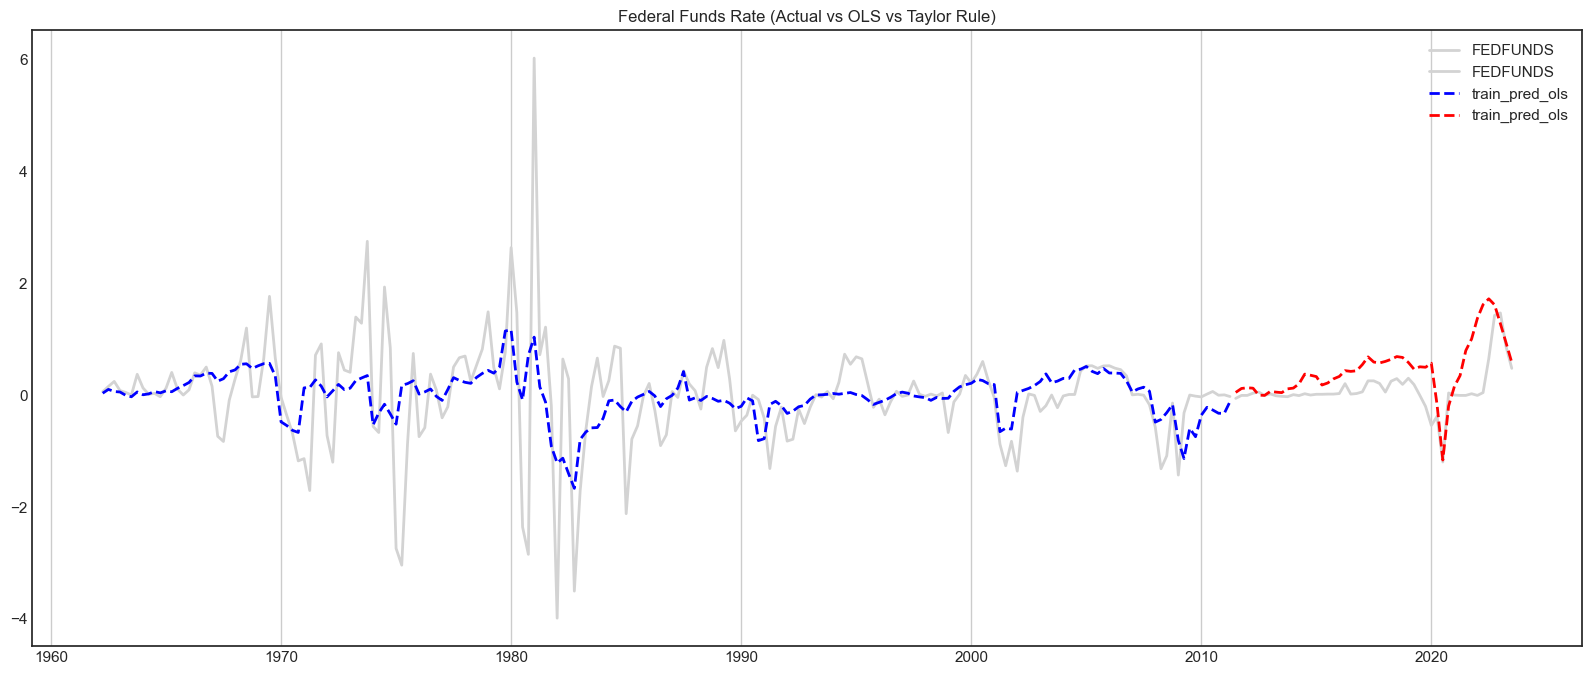

In [248]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# LGBM

In [249]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_lgbm = ltb_model.predict(X_train_trf, pred_contrib=False, raw_score=False)

<Axes: >

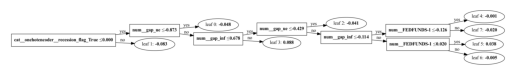

In [250]:
ltb.plot_tree(ltb_model)

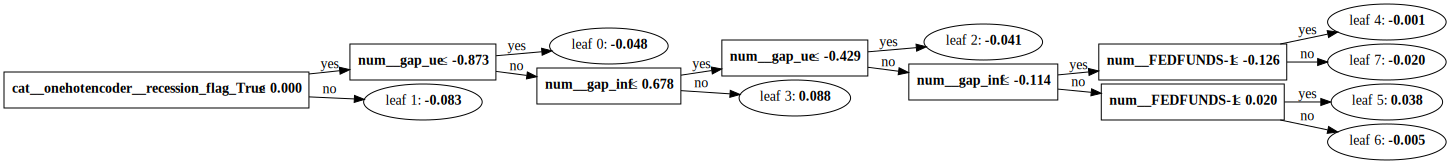

In [251]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

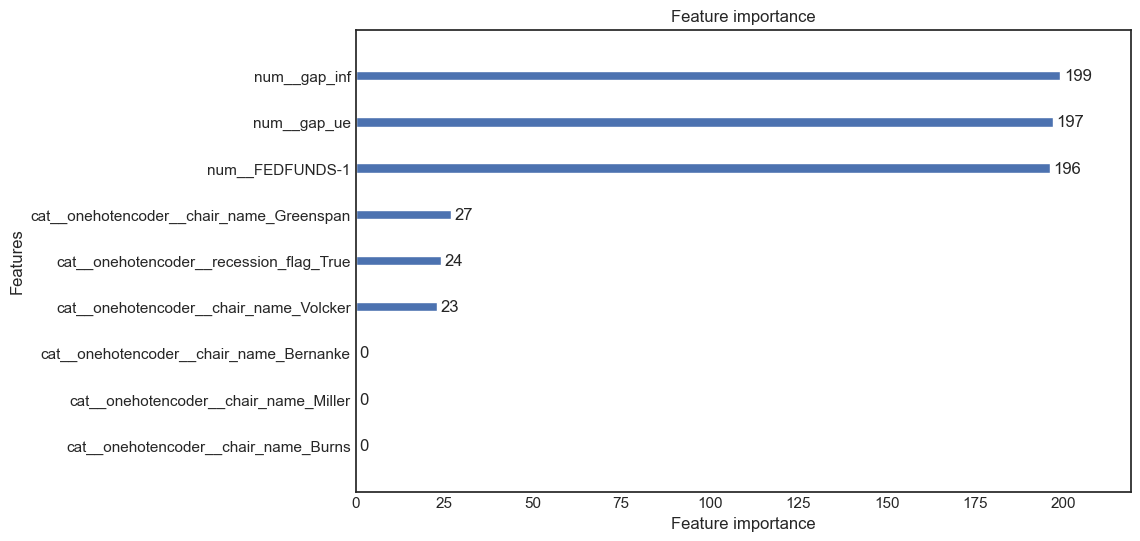

In [252]:
ltb.plot_importance(ltb_model, ignore_zero=False, grid=False, figsize=(10,6))

In [253]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], 2  , model_stats_df )

## Test

In [254]:
test_pred_lgbm = ltb_model.predict(X_test_trf, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(49,)

In [255]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_train.shape[0], 2 , model_stats_df )

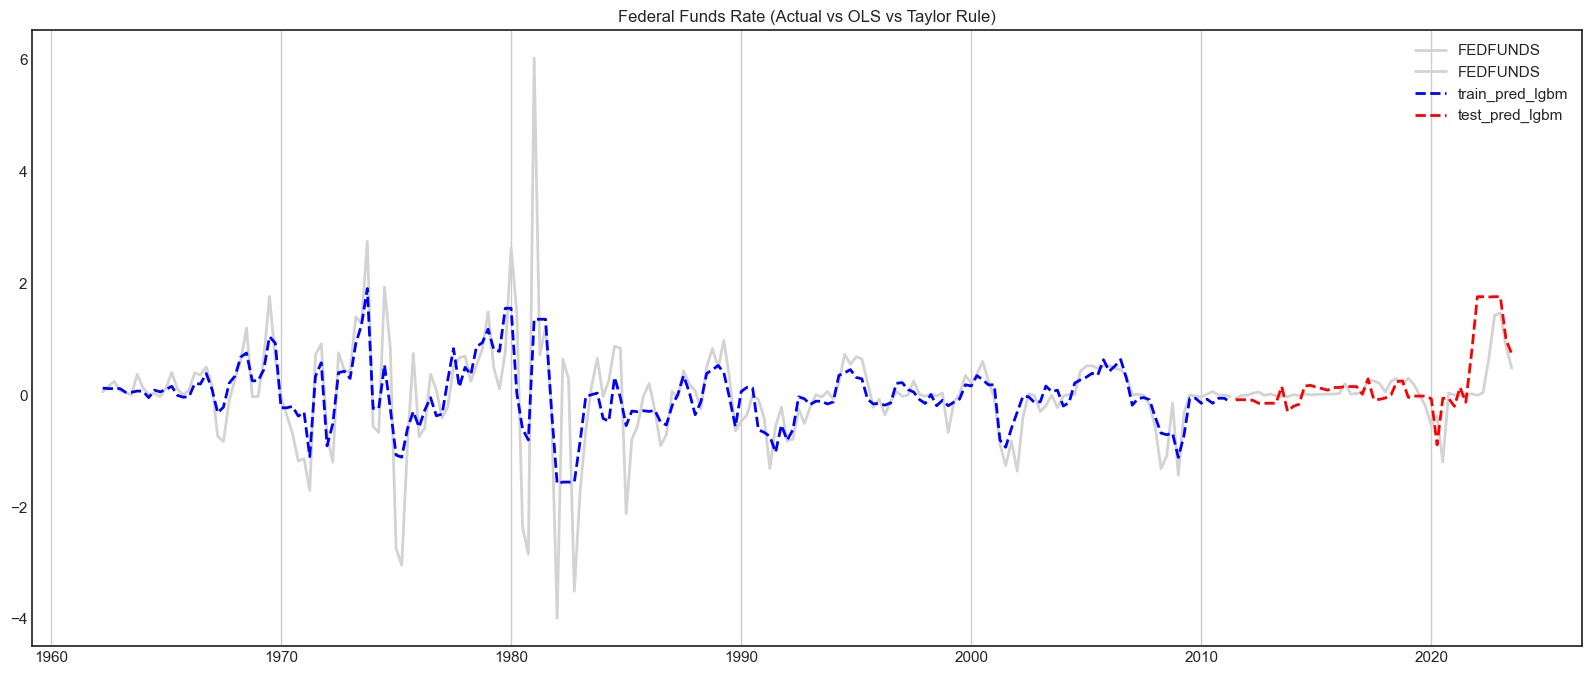

In [256]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# XGB

In [257]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_xgb = xgb_model.predict(X_train_trf)
xgb_model.score(X_train_trf, y_train)

0.9999849243100077

In [258]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], 2 , model_stats_df )

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

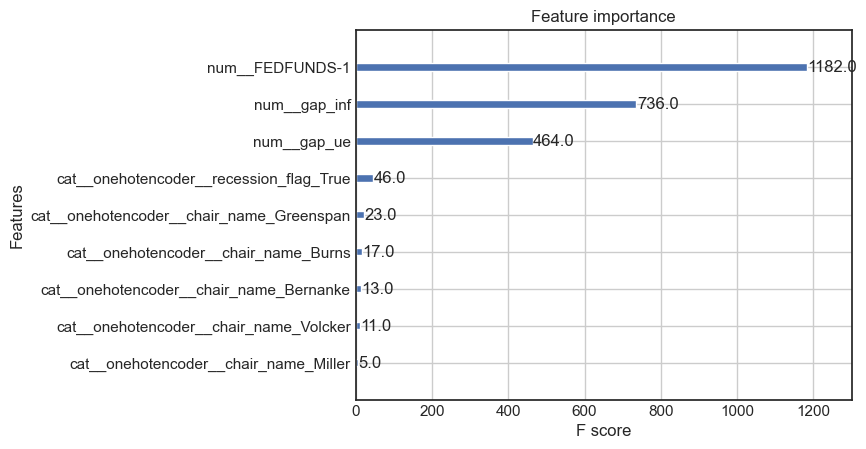

In [259]:
xgb.plot_importance(xgb_model)

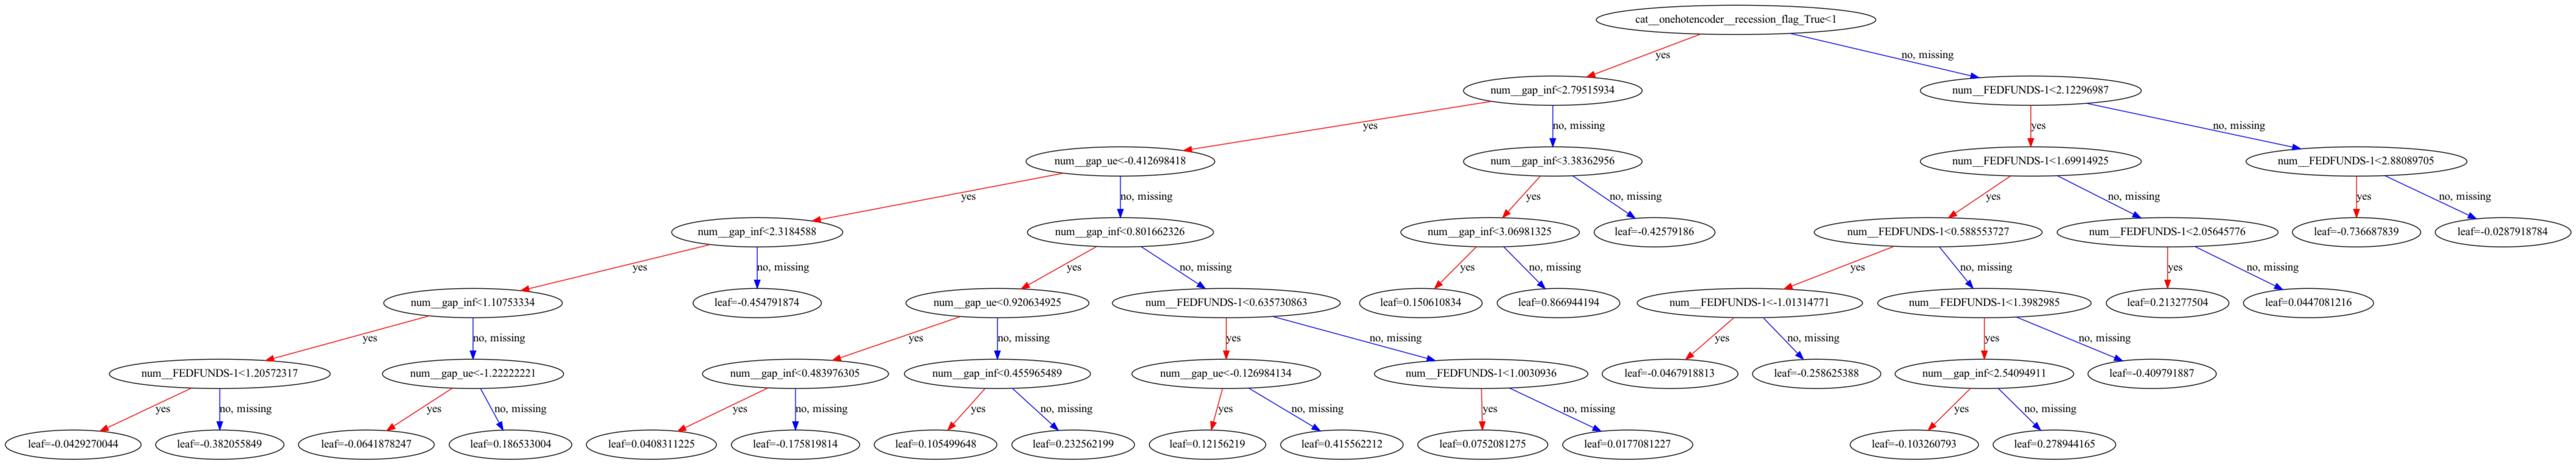

In [260]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

## Test

In [261]:
test_pred_xgb = xgb_model.predict(X_test_trf)
test_pred_xgb.shape

(49,)

In [262]:
model_stats_df = model_results('xgb_test', y_test, test_pred_xgb, X_train.shape[0], 2 , model_stats_df )

# AdaBoostRegressor

In [263]:
ada_model = AdaBoostRegressor().fit(X_train_trf, y_train)
train_pred_ada = ada_model.predict(X_train_trf)

model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

In [264]:
test_pred_ada = ada_model.predict(X_test_trf)
model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

# tsa.SARIMAX

In [265]:
model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          FEDFUNDS_diff   No. Observations:                  197
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -242.121
Date:                Mon, 27 Nov 2023   AIC                            506.243
Time:                        20:55:47   BIC                            542.358
Sample:                    03-31-1962   HQIC                           520.863
                         - 03-31-2011                                         
Covariance Type:                  opg                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
num__FEDFUNDS-1                             -0.9388      0.260     -3.615      0.000      -1.448      -0.430
num__gap_inf                                 0.5799      0.107      5.420      0.000       0.370       0.790
num__gap_ue                                  0.5004      0.157      3.188      0.001       0.193       0.808
cat__onehotencoder__recession_flag_True     -0.7373      0.225     -3.273      0.001      -1.179      -0.296
cat__onehotencoder__chair_name_Burns        -0.1339      0.213     -0.630      0.529      -0.551       0.283
cat__onehotencoder__chair_name_Miller        0.1898      0.830      0.229      0.819      -1.437       1.816
cat__onehotencoder__chair_name_Volcker       1.0983      0.366      3.002      0.003       0.381       1.815
cat__onehotencoder__chair_name_Greenspan    -0.0828      0.239     -0.346      0.729      -0.551       0.386
cat__onehotencoder__chair_name_Bernanke     -0.0850      0.537     -0.158      0.874      -1.138       0.968
ar.L1                                        0.2092      0.069      3.036      0.002       0.074       0.344
sigma2                                       0.6839      0.043     16.043      0.000       0.600       0.767
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               825.74
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [266]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [267]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS_diff      mean   mean_se  mean_ci_lower  mean_ci_upper
1962-03-31     0.162977  0.845673      -1.494512       1.820467
1962-06-30     0.258995  0.845673      -1.398494       1.916485
1962-09-30     0.196835  0.845673      -1.460654       1.854325
1962-12-31     0.172619  0.845673      -1.484870       1.830109
1963-03-31     0.085747  0.845673      -1.571742       1.743237
...                 ...       ...            ...            ...
2010-03-31    -0.128002  0.845673      -1.785491       1.529488
2010-06-30    -0.200846  0.845673      -1.858335       1.456644
2010-09-30    -0.291516  0.845673      -1.949005       1.365973
2010-12-31    -0.292574  0.845673      -1.950064       1.364915
2011-03-31     0.006301  0.845673      -1.651189       1.663790

[197 rows x 4 columns]

In [268]:
model_stats_df = model_results('SARIMAX_train',train_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0],X_train.shape[1] , model_stats_df )

## Test

In [269]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [270]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(49, 4)

In [271]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

lower FEDFUNDS_diff  upper FEDFUNDS_diff
2011-06-30            -0.315744             0.799800
2011-09-30            -0.216612             0.923090
2011-12-31            -0.202044             0.938704
2012-03-31            -0.217541             0.923253
2012-06-30            -0.400515             0.740281

In [272]:
model_stats_df = model_results('SARIMAX_test', test_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_train.shape[1] , model_stats_df )

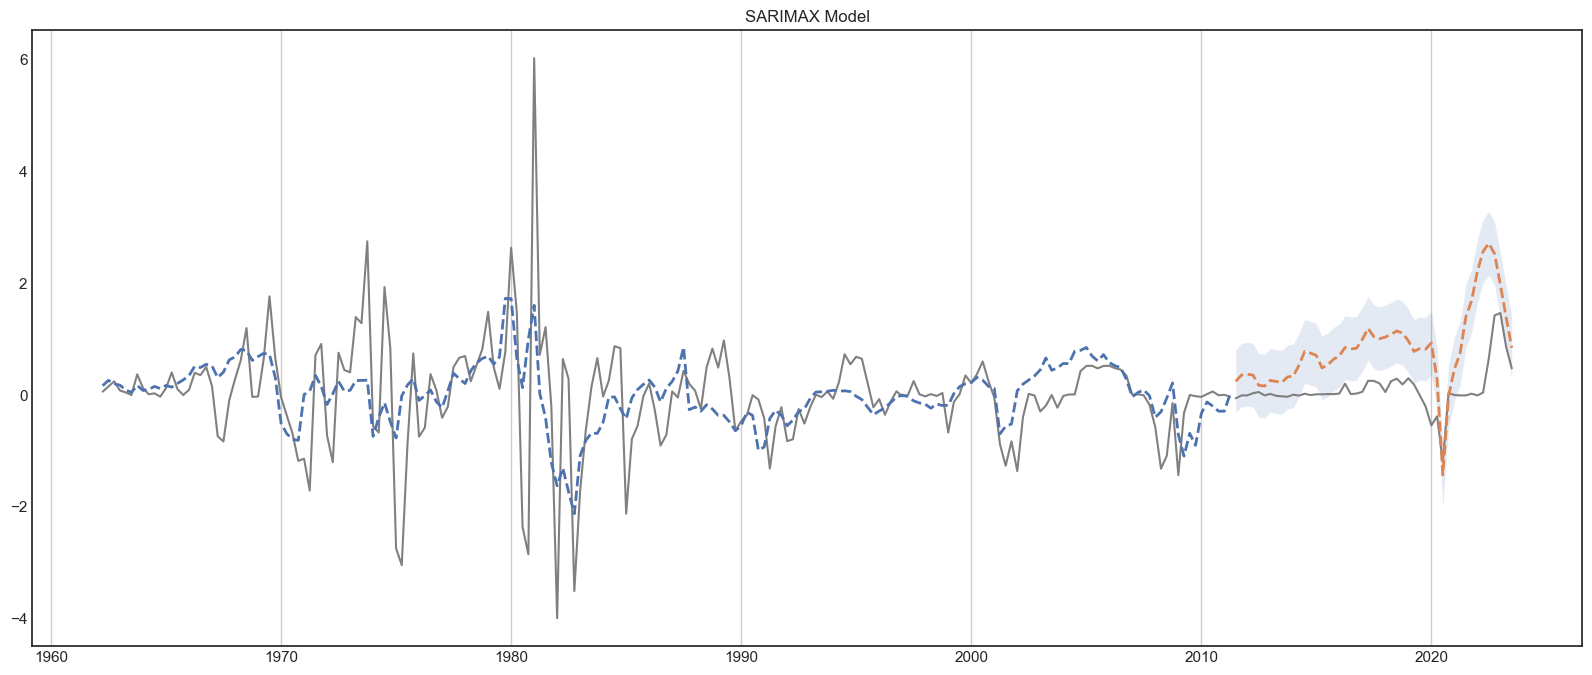

In [273]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS_diff'], predict_ci['upper FEDFUNDS_diff'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [274]:
model_stats_df

name     r_sq  adj_r_sq      mse    rmse
0    ffef_tr_train   0.0328    0.0279   0.9061  0.9519
1     ffef_tr_test -13.6332  -13.9446   2.2484  1.4995
2   ffef_tr2_train  -0.3337   -0.3406   1.2494  1.1178
3    ffef_tr2_test   0.5059    0.4954   0.0759  0.2755
4      Naive_train  -0.0001   -0.0001   0.9369  0.9680
5       Naive_test  -0.0633   -0.0633   0.1634  0.4042
6        ols_train   0.2487    0.2449   0.7038  0.8389
7         ols_test  -1.5783   -1.6332   0.3962  0.6294
8      lasso_train   0.2353    0.2313   0.7164  0.8464
9       lasso_test  -0.6201   -0.9441   0.2489  0.4989
10      lgbm_train   0.5462    0.5439   0.4251  0.6520
11       lgbm_test  -0.4400   -0.4474   0.2213  0.4704
12       xgb_train   1.0000    1.0000   0.0000  0.0038
13        xgb_test  -0.6208   -0.6291   0.2490  0.4990
14        ada_test   0.6490    0.6472   0.3288  0.5734
15        ada_test  -0.1111   -0.1168   0.1707  0.4132
16   SARIMAX_train  -3.0058   -3.0892  46.8868  6.8474
17    SARIMAX_test   0.0228   -0.0661   1.3550  1.1640